# Simple example notebook 
1. generate an instance of SK model
2. Load a sk-1rsb autoregressive architecture
3. Train its parameters on the Boltzmann distribution of the SK model

In [1]:
import networkx as nx
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import random
#torch.set_num_threads(1)

import python_lib.graph_gen as graph_gen
import python_lib.models as models
#from python_lib import solvers

from python_lib.nets import h2arnn
from python_lib import run_lib

In [2]:
%matplotlib inline

# Sherrington Kirkpatrick

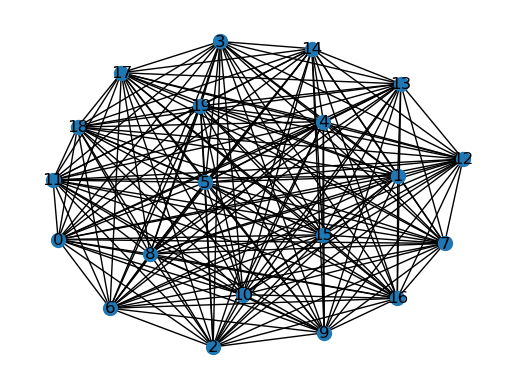

In [3]:
seed=0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
N = 20
fig, ax0 = plt.subplots(1,1)
J_interaction = torch.ones(N,N) - torch.eye(N, N)

inter_H = 0
H = inter_H * (torch.ones(N))
J_sigma_val=1
J_0_val=0
if N < 200:
    graph_gen.plot_matrix_graph(J_interaction, ax0)

J_prob = graph_gen.spin_glass(N, J = J_sigma_val, J_0 = J_0_val)
J = graph_gen.set_J(J_interaction, J_prob)


# Exact solutions
enumerating all configurations.
Th. results

In [4]:
from python_lib.models import spins_model

device="cpu"
SK_model = spins_model.model(N, H, J, J_interaction, device=device)
beta_fin=2
beta_init = 0.1
step = 39
betas = np.linspace(beta_init, beta_fin, step)

stats_step=1

In [5]:
from python_lib.models import spins_model


SK_model_exact = spins_model.model(N, H, J, J_interaction, device=device)
f_exact = []
f_exact_infN = []
steps = 0
if N < 25:
    for beta_ in betas:
        if steps % stats_step == 0:
            f_exact.append(SK_model_exact.exact(beta_))
        steps += 1
else:
    print("sorry systems too bog for exact computation")


beta: 0.1, Fe: -6.956 Energy: -0.0498 M: 4.14e-08 S: 0.6916      
beta: 0.1, Fe: -4.658 Energy: -0.0747 M: 1.23e-08 S: 0.6886      
beta: 0.2, Fe: -3.516 Energy: -0.0998 M: 4.86e-09 S: 0.6832      
beta: 0.2, Fe: -2.835 Energy: -0.125 M: -6.65e-09 S: 0.6773      
beta: 0.3, Fe: -2.385 Energy: -0.15 M: -1.07e-08 S: 0.67.39      
beta: 0.3, Fe: -2.068 Energy: -0.176 M: 1.65e-08 S: 0.66207      
beta: 0.4, Fe: -1.833 Energy: -0.202 M: 1.28e-09 S: 0.65283      
beta: 0.4, Fe: -1.653 Energy: -0.228 M: 3.36e-09 S: 0.64165      
beta: 0.5, Fe: -1.512 Energy: -0.255 M: 1.68e-08 S: 0.62951      
beta: 0.5, Fe: -1.399 Energy: -0.281 M: 1.84e-09 S: 0.6154       
beta: 0.6, Fe: -1.307 Energy: -0.308 M: 3.65e-08 S: 0.59931      
beta: 0.6, Fe: -1.231 Energy: -0.335 M: 3.18e-09 S: 0.58223      
beta: 0.7, Fe: -1.168 Energy: -0.362 M: 4.02e-09 S: 0.56417     
beta: 0.7, Fe: -1.115 Energy: -0.388 M: 1.12e-08 S: 0.54512      
beta: 0.8, Fe: -1.071 Energy: -0.414 M: -8.69e-09 S: 0.5257      
beta: 0.8, 

# Train net

In [6]:
lr = 0.001
max_step = 1000
batch_size=2000
std_fe_limit=1e-4
batch_iter=20
stats_step=1

In [7]:
rho = h2arnn.SK_krsb
learn_first_layer = False
dict_nets = {"k": 1, "set_exact": False}
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
net = h2arnn.h2arnn(
    SK_model, rho, input_mask, device=device, dict_nets=dict_nets, learn_first_l=learn_first_layer)

Total Trainable Params: 1940
Total Params: 1940


In [9]:
stats = run_lib.train_net(net,
                    betas,
                    lr=lr,
                    max_step=max_step,
                    batch_size=batch_size,
                    std_fe_limit=std_fe_limit,
                    batch_iter=batch_iter,
                    stats_step=stats_step,
                    )

step: 595 1.00000 fe: -0.949 +- 0.00450 E: -0.501, S: 0.447, M: 0.339 sample_t : 0.026 log_prob : 0.024 loss : 0.00016 optimizer : 0.014 stats : 0.01188